# Machine Learning: Analysis and Prediction of League of Legend Games

Jordy Berlanger, Computer Scientist (2022)

## Libraries

The libraries that are used in this project will be loaded in here. These provide us handy tools for calculations, data representation, (predictive) data analysis, etc. This way we do not have to implement everything from scratch ourselves.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image

## The game

League of Legends is a MOBA (multiplayer online battle arena) style of game. Ten players, divided in two teams (blue and red), get to pick champions from an elaborate champion roster and fight against each other. The game can be ended in two ways, namely by destroying the enemy Nexus, or by surrendering once all hope of winning is lost. There are many elements in the game, and the following glossary will explain a few of them.

* **Level**: Champions each have a level ranging from 1 to 18. You level your champion up by defeating enemies, minions or by completing objectives.
* **Towers**: Towers are structures that defend the lanes to the Nexus. These have to be destroyed to ensure a safe lane to the enemy Nexus.
* **Minions**: Minions are non-playable characters that both teams have. Players can kill them to obtain gold.
* **Jungle minions**: Jungle minions are neutral and give gold and statistical advantages to the player or team killing them.
* **Elite monsters**: Elite monsters give statistical advantages to the player or team defeating them.
* **Herald**: The herald is an elite monster that helps the player that defeats it to clear a lane from structures.
* **Dragon**: The dragon is an elite monster that gives the team that defeats it an advantage. One spawns every five minutes, starting from the fifth minute into the game.
* **Warding totem**: An item that can be purchased by a player that will allow the team to see what is happening in the location the totem is planted. Without this totem, fog of war will cover this location and you will not be able to see what is going on unless there is a structure, or your missions are passing through.

These elements all play a role in the outcome of the game and are thus relevant for the analysis and the training of the prediction model.

## The dataset

This project will delve into data analysis and prediction for League of Legends games. This means that we will analyse the data of +/- 10.000 League of Legends (diamond rank to low master rank) games to see which factors differ the most between wins and losses. Based on the data of these games, we will also train a model that will predict the outcome of future games with a certain accuracy. The last step will be tweaking parameters of this model, to maximise its accuracy.

The data was downloaded from this [page](https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min). Thanks for providing it.

In [2]:
# Reading data into a DataFrame using pandas

import pandas as pd
df = pd.read_csv("league_game_data.csv")

# The game ID should not be used for training, so we omit that column
df.drop('gameId', inplace=True, axis=1)

# Print columns of the dataset with their min and max values
print("DATASET INFORMATION:\n")
print(" - Dataset has", len(df), "entries with the following columns.")
print(" - Entries have the following columns:")
print(f"\n\t{'Column':30s} | {'Type':8s} | {'Min':8s} | {'Max':8s}\n")
for col_name in df.columns:
    col = df[col_name]
    print(f"\t{col_name:30s} | {str(col.dtype):8s} | {col.min():8.1f} | {col.max():8.1f}")

DATASET INFORMATION:

 - Dataset has 9879 entries with the following columns.
 - Entries have the following columns:

	Column                         | Type     | Min      | Max     

	blueWins                       | int64    |      0.0 |      1.0
	blueWardsPlaced                | int64    |      5.0 |    250.0
	blueWardsDestroyed             | int64    |      0.0 |     27.0
	blueFirstBlood                 | int64    |      0.0 |      1.0
	blueKills                      | int64    |      0.0 |     22.0
	blueDeaths                     | int64    |      0.0 |     22.0
	blueAssists                    | int64    |      0.0 |     29.0
	blueEliteMonsters              | int64    |      0.0 |      2.0
	blueDragons                    | int64    |      0.0 |      1.0
	blueHeralds                    | int64    |      0.0 |      1.0
	blueTowersDestroyed            | int64    |      0.0 |      4.0
	blueTotalGold                  | int64    |  10730.0 |  23701.0
	blueAvgLevel                   | fl

## Data analysis

Firstly, redundant features or features that can be derived will be removed. The feature values that are calculated per minute are a prime example, because we can just use the total amount, and divide it by the amount of minutes that have passed if necessary. Moreover, dragons and heralds are considered elite monsters, so the two subfeatures can be removed. Moreover, dragons and heralds are elite monsters, so the elite monsters feature can be removed.

In [3]:
# Remove reduntant data, or data that can be derived
blue_columns = ['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills', 'blueDeaths',
                'blueAssists', 'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold',
                'blueAvgLevel', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled']
red_columns = ['blueWins', 'redWardsPlaced', 'redWardsDestroyed', 'redFirstBlood', 'redKills', 'redDeaths',
                'redAssists', 'redDragons', 'redHeralds', 'redTowersDestroyed', 'redTotalGold',
                'redAvgLevel', 'redTotalMinionsKilled', 'redTotalJungleMinionsKilled']

blue_column_names = ['Win', 'Wards placed', 'Wards destroyed', 'First blood', 'Kills', 'Deaths', 'Assists',
                    'Dragons', 'Heralds', 'Towers destroyed', 'Total gold', 'Average level', 'Total minions killed',
                    'Total jungle minions killed']
red_column_names = ['Loss', 'Wards placed', 'Wards destroyed', 'First blood', 'Kills', 'Deaths', 'Assists',
                    'Dragons', 'Heralds', 'Towers destroyed', 'Total gold', 'Average level', 'Total minions killed',
                    'Total jungle minions killed']

df_blue = df[blue_columns]
df_blue.columns = blue_column_names
df_red = df[red_columns]
df_red.columns = red_column_names

In [4]:
df.corr()['blueWins'][:-1].sort_values()

redGoldDiff                    -0.511119
redExperienceDiff              -0.489558
redTotalGold                   -0.411396
redTotalExperience             -0.387588
redAvgLevel                    -0.352127
redKills                       -0.339297
blueDeaths                     -0.339297
redAssists                     -0.271047
redEliteMonsters               -0.221551
redTotalMinionsKilled          -0.212171
redCSPerMin                    -0.212171
redDragons                     -0.209516
redFirstBlood                  -0.201769
redTotalJungleMinionsKilled    -0.110994
redTowersDestroyed             -0.103696
redHeralds                     -0.097172
redWardsDestroyed              -0.055400
redWardsPlaced                 -0.023671
blueWardsPlaced                 0.000087
blueWardsDestroyed              0.044247
blueHeralds                     0.092385
blueTowersDestroyed             0.115566
blueTotalJungleMinionsKilled    0.131445
blueFirstBlood                  0.201769
blueDragons     

These numbers can be plotted on a heatmap, so it is easier to see the the correlation values between the different features. The correlation between average level and the amount of kills can be seen this way as well, not just whether the player has won or not.

<AxesSubplot:title={'center':'Blue team'}>

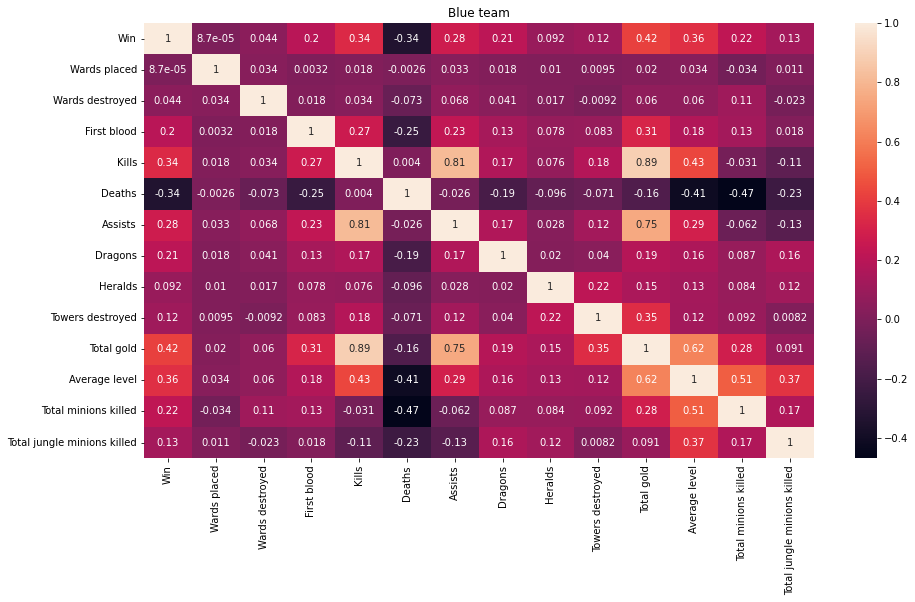

In [5]:
plt.figure(figsize = (15,8))
plt.title("Blue team")
sns.heatmap(df_blue.corr(), annot = True)

There are no surprising results that can be observed from this heatmap. Total gold has a strong positive correlation with winning, since gold allows you to buy items that make you stronger. Hence there is a strong positive correlation between the amount of gold a player has and the amount of kills a player makes. Since kills award a certain amount of experience, the amount of kills also has a strong positive correlation with the average level of a player. On the other hand, all these features have a negative correlation with the amount of deaths a player has.

The only observation that stands out is that heralds seemingly do not contribute much to a win. Having a herald deployed against you in a lane in the game can be quite unforgiving, but it seems that it does not influence the game as much as a player would think.

## Training models

This section will deal with creating predictive models and training them. These models will be able to predict whether or not a game of League of Legends can be won after ten minutes according to a certain accuracy, given a set of input data for which patterns will be analyzed in the training proces. Eventually, different model types will be compared to each other after hyperparameter optimization to ultimately find the best one for this use case.

### Preprocessing data

Redudant features and features that contained data that could be derived were already removed, but now features that show little variance will be removed as well. This process is called feature engineering or feature extraction.

#### Feature engineering

In [6]:
# Remove reduntant data, or data that can be derived
columns = blue_columns + red_columns[1:]
df = df[columns]

# Give the columns a more human readable name
column_names = ['Win', 'Blue wards placed', 'Blue wards destroyed', 'Blue first blood', 'Blue kills', 'Blue deaths',
                'Blue assists', 'Blue dragons', 'Blue heralds', 'Blue towers destroyed',
                'Blue total gold', 'Blue average level', 'Blue total minions killed','Blue total jungle minions killed',
                'Red wards placed', 'Red wards destroyed', 'Red first blood', 'Red kills', 'Red deaths', 'Red assists',
                'Red dragons', 'Red heralds', 'Red towers destroyed', 'Red total gold',
                'Red average level', 'Red total minions killed', 'Red total jungle minions killed']
df.columns = column_names

In [7]:
# We remove the features that have a low variance in their values using VarianceThreshold of SciKit.
sel = VarianceThreshold(threshold = (.8 * (1 - .8)))
sel.fit(df)
# We get the indices of the columns that will be retained because their variance is high enough.
retained_columns = sel.get_support(indices=True)
retained_column_names = []

print("The statistics that have a high enough variance are:")
for i in retained_columns:
    retained_column_names.append(column_names[i])
    print(f" - {column_names[i]}")
    
# We have a look at what columns are removed as well.
all_columns = [i for i in range(len(df.columns))]
removed_columns = list(set(all_columns) - set(retained_columns))
removed_column_names = []

print("\nThe statistiscs that have too low of a variance are:")
for i in removed_columns:
    removed_column_names.append(column_names[i])
    print(f" - {column_names[i]}")

The statistics that have a high enough variance are:
 - Win
 - Blue wards placed
 - Blue wards destroyed
 - Blue first blood
 - Blue kills
 - Blue deaths
 - Blue assists
 - Blue dragons
 - Blue total gold
 - Blue total minions killed
 - Blue total jungle minions killed
 - Red wards placed
 - Red wards destroyed
 - Red first blood
 - Red kills
 - Red deaths
 - Red assists
 - Red dragons
 - Red total gold
 - Red total minions killed
 - Red total jungle minions killed

The statistiscs that have too low of a variance are:
 - Blue heralds
 - Blue towers destroyed
 - Blue average level
 - Red heralds
 - Red towers destroyed
 - Red average level


Since these features have a low variance, they will not influence the outcome of a game much. These features can thus be considered irrelevant during the training of the model.

In [8]:
df.drop(columns=removed_column_names, axis=1, inplace=True)

# Print retained columns of the dataset with their min and max values
print("Entries now have the following remaining columns:")
print(f"\n\t{'Column':32s} | {'Type':8s} | {'Min':8s} | {'Max':8s}\n")
for col_name in df.columns:
    col = df[col_name]
    print(f"\t{col_name:32s} | {str(col.dtype):8s} | {col.min():8.1f} | {col.max():8.1f}")

Entries now have the following remaining columns:

	Column                           | Type     | Min      | Max     

	Win                              | int64    |      0.0 |      1.0
	Blue wards placed                | int64    |      5.0 |    250.0
	Blue wards destroyed             | int64    |      0.0 |     27.0
	Blue first blood                 | int64    |      0.0 |      1.0
	Blue kills                       | int64    |      0.0 |     22.0
	Blue deaths                      | int64    |      0.0 |     22.0
	Blue assists                     | int64    |      0.0 |     29.0
	Blue dragons                     | int64    |      0.0 |      1.0
	Blue total gold                  | int64    |  10730.0 |  23701.0
	Blue total minions killed        | int64    |     90.0 |    283.0
	Blue total jungle minions killed | int64    |      0.0 |     92.0
	Red wards placed                 | int64    |      6.0 |    276.0
	Red wards destroyed              | int64    |      0.0 |     24.0
	Red first

#### Splitting data

In the next step, the data will be split among three groups:
* **Training data**: This data will be used to fit the models.
* **Validation data**: This data will be used to tune the hyperparameters to become the best possible accuracy. This is separate from the training data to avoid overfitting the model. This way, the model avoids becoming too specific for the data it was trained on, thus leading to a possible higher accuracy of prediction on future unseen data.
* **Test data**: Final comparisons of accuracy can be done on the test data, to see how the models compare on unseen data.

A split of 70% training data, 15% validation data and 15% test data was chosen.

In [9]:
train_df_size = 0.7
rest_df_size = 1 - train_df_size
test_df_size = 0.5

train_df, rest_df = train_test_split(df, test_size=rest_df_size)
val_df, test_df = train_test_split(rest_df, test_size=test_df_size)

X_train = train_df.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]] # can be written with list(set(df[features])-set(df[target])))
y_train = train_df.iloc[:,[0]]

X_val = val_df.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]] # can be written with list(set(df[features])-set(df[target])))
y_val = val_df.iloc[:,[0]]

X_test = test_df.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]] # can be written with list(set(df[features])-set(df[target])))
y_test = test_df.iloc[:,[0]]

print("Partitioning of the data:\n")
print(f" - Train data: {len(train_df)} samples (70% of the data).")
print(f" - Validation data: {len(val_df)} samples (15% of the data).")
print(f" - Test data:  {len(test_df)} samples (15% of the data).")

Partitioning of the data:

 - Train data: 6915 samples (70% of the data).
 - Validation data: 1482 samples (15% of the data).
 - Test data:  1482 samples (15% of the data).


### Training models

Several models will be trained, so in the end a comparison can be done to see which one can predict the outcome of a League of Legends game better after 10 minutes. The models that will be trained are a K-Nearest Neighbour model, a classic Decision Tree Classifier, a Neural Network, Logistic Regression model and finally a Naive Bayes model.

#### KNN classificatier

The KNN algorithm is a supervised learning approach that works with data points in a space, and assumes that data points within the same class are close/similar to each other. It will consider a K amount of nearest neighbours, and based on their classifications, it will classify the new data point accordingly. It all comes down to the right choice of K. Or in other words: how many nearest neighbouring data points do we want to consider for the classification of a new data point?

A value of K = 1 would lead to a lot of incorrect predictions, because we are only considering the nearest data point which means there is no averaging going on at all. A value too high will lead to overgeneralisation where a lot of errors will take place, and accuracy declines again.

Scikit's API provides all the classes and functions needed to train such a model.

In [10]:
ks = [1, 2, 3, 4, 5, 8, 10, 15, 20, 25, 50, 75, 100, 200, 300, 400, 500, 750, 1000]
knn_scores = []

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train['Win'].to_numpy())
    score = knn.score(X_val, y_val['Win'])
    knn_scores.append(score)
    print(f"k = {k}: score = {score}")

k = 1: score = 0.6403508771929824
k = 2: score = 0.6369770580296896
k = 3: score = 0.6605937921727395
k = 4: score = 0.6612685560053981
k = 5: score = 0.6794871794871795
k = 8: score = 0.6828609986504723
k = 10: score = 0.6882591093117408
k = 15: score = 0.6983805668016194
k = 20: score = 0.7091767881241565
k = 25: score = 0.7112010796221323
k = 50: score = 0.7226720647773279
k = 75: score = 0.733468286099865
k = 100: score = 0.7375168690958165
k = 200: score = 0.7341430499325237
k = 300: score = 0.7375168690958165
k = 400: score = 0.7361673414304993
k = 500: score = 0.733468286099865
k = 750: score = 0.7341430499325237
k = 1000: score = 0.7341430499325237


k = 100 yields the highest result, namely 0.7375168690958165


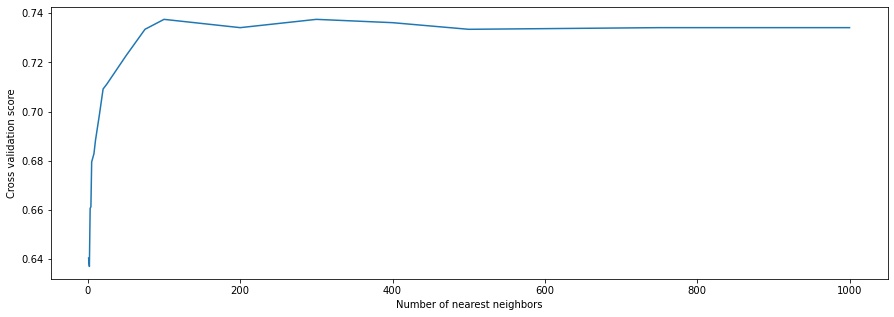

In [11]:
max_score = max(knn_scores)
k_max_score = ks[knn_scores.index(max_score)]

plt.figure(figsize=(15,5))
plt.ylabel("Cross validation score")
plt.xlabel("Number of nearest neighbors")
sns.lineplot(x=ks, y=knn_scores)

print(f"k = {k_max_score} yields the highest result, namely {max_score}")

#### Decision tree classifier

Decision tree classifier is a supervised learning approach that works like a tree structure, hence the mention of the word tree in the name. Nodes of the tree represent features (amount of gold, amount of elite monsters, etc.), and these nodes branch out to other nodes depending on decision rules (amount of gold > x, amount of elite monsters > y, etc.). The leaf nodes at the bottom of the tree are the outcomes (win or loss).

When we fit the model with the training data, the tree will be constructed. The validation data will determine what depth of the tree works best. In the end, the test data will be used to see how the tree works on unseen data. This unseen data will, depending on the decision rules in each node of the tree, traverse a path to a leaf node which will classify the new instance as either a win, or a loss.

The wonderful Scikit API allows the use their implementation of the decision tree classifier.

In [12]:
# Decision techniques to consider for the decision tree classifier
params = {
    'criterion':  ['gini', 'entropy'],
    'splitter': ['best', 'random']
}

# We can try all of these using GridSearchCV by Scikit.
clf = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=params,
    cv=4, # cross validation
    n_jobs=5, # jobs in parallel
    verbose=1,
)

clf.fit(X_val, y_val)
best_tree_pms = clf.best_params_

print(f"\nBest techniques for the tree are:")
for pm in best_tree_pms.keys():
    print(f" - {pm} = {best_tree_pms[pm]}")

Fitting 4 folds for each of 4 candidates, totalling 16 fits

Best techniques for the tree are:
 - criterion = entropy
 - splitter = random


The **criterion** is a parameter that rules the attribution choice selection measure. The **splitter** parameter stands for the split strategy. Lastly, the **maximum depth** of the tree is a parameter that allows us to limit the tree size.

In [13]:
ds = [1, 2, 3, 4, 5, 8, 10, 15, 20, 25, 50, 75]
tree_scores = []

for d in ds:
    tree = DecisionTreeClassifier(criterion=best_tree_pms['criterion'], splitter=best_tree_pms['splitter'], max_depth=d).fit(X_train, y_train['Win'].to_numpy())
    score = tree.score(X_val, y_val['Win'])
    tree_scores.append(score)
    print(f"depth = {d}: score = {score}")

depth = 1: score = 0.6788124156545209
depth = 2: score = 0.655195681511471
depth = 3: score = 0.7064777327935222
depth = 4: score = 0.7145748987854251
depth = 5: score = 0.7098515519568152
depth = 8: score = 0.7165991902834008
depth = 10: score = 0.7118758434547908
depth = 15: score = 0.6666666666666666
depth = 20: score = 0.634952766531714
depth = 25: score = 0.6376518218623481
depth = 50: score = 0.6288798920377868
depth = 75: score = 0.6194331983805668


We can see that lower depths lead to less accuracy until we reach a peak, but then the accuracy decreases as we increase the maximum depth.

depth = 8 yields the highest result, namely 0.7165991902834008


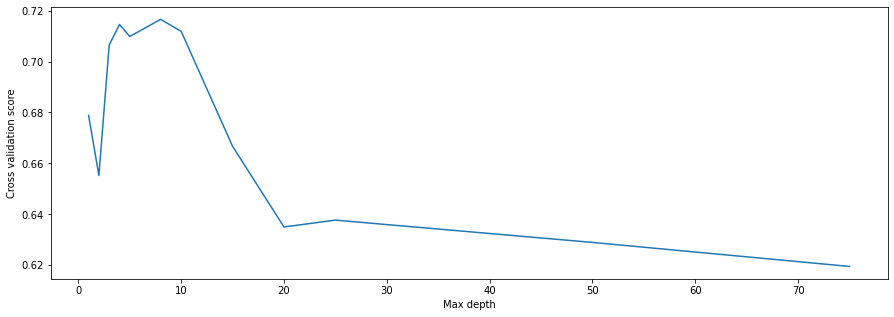

In [14]:
max_score = max(tree_scores)
tree_max_score = ds[tree_scores.index(max_score)]

plt.figure(figsize=(15,5))
plt.ylabel("Cross validation score")
plt.xlabel("Max depth")
sns.lineplot(x=ds, y=tree_scores)

print(f"depth = {tree_max_score} yields the highest result, namely {max_score}")

Visualizing the tree shows that the tree attaches a lot of value to the amount of gold the red or blue team has to make a decision, since that is the primary feature the decision rules are based on. However, first blood, deaths and dragons are mentioned too.

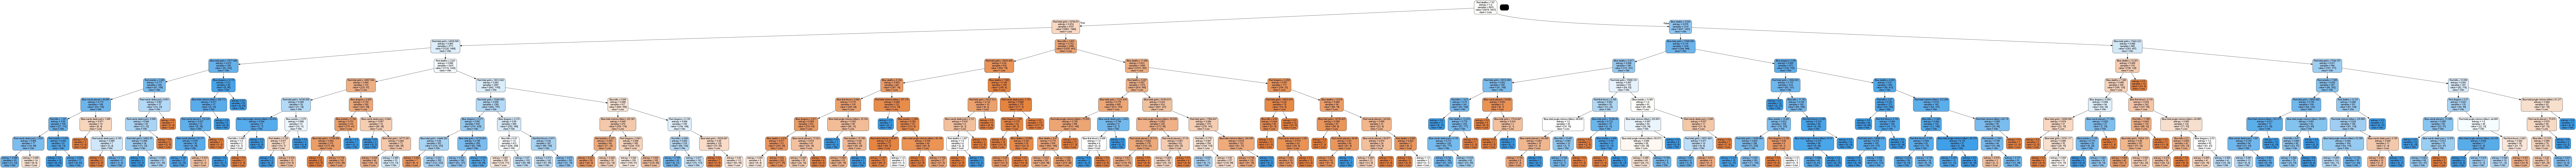

In [15]:
tree = DecisionTreeClassifier(criterion=best_tree_pms['criterion'], splitter=best_tree_pms['splitter'], max_depth=tree_max_score).fit(X_train, y_train['Win'].to_numpy())
data = StringIO()
export_graphviz(tree, out_file=data,
               filled=True, rounded=True,
               special_characters=True, feature_names=X_train.columns, class_names=['Loss', 'Win'])
graph = pydotplus.graph_from_dot_data(data.getvalue())
graph.write_png('clf.png')
Image(graph.create_png())

#### Neural network

Artificial neural networks (ANN) can also be used to predict the outcome of a League of Legends game. An ANN can be visualised as a multi-layered structure in which a layer consists of a row of neurons. Neurons receive an input and produce an output (using weights and an activation function) that can be passed to another layer of neurons. The outer two layers that sandwich the others are called the input and output layer. The input layer receives the input data, and the output layer produces the mapped result after the invisible layers have done all their mapping.

However, this method requires another step before we train the ANN itself. An ANN is rarely exposed to raw data, so first the data will have to be normalised so that the value of the features are scaled to a value between 0 and 1. Once we feed this data to the ANN, it will learn how to map the data to either a win or a loss.

In [16]:
# TRAINING DATA
# Normalise the independent variables
X_train_norm = X_train/X_train.max()

# Get the numpy arrays for the input of the neural network
Nn_train_x = X_train_norm.values
Nn_train_y = y_train['Win'].to_numpy()

# VALIDATION DATA
# Normalise the independent variables
X_val_norm = X_val/X_val.max()

# Get the numpy arrays for the input of the neural network
Nn_val_x = X_val_norm.values
Nn_val_y = y_val['Win'].to_numpy()

There are many rules that describe the desired amount of hidden layers and the amount of neurons they have. In 'Introduction to Neural Networks for Java" (second edition) by Jeff Heaton, the following rule-of-thumbs methods are listed:

For the amount of hidden layers he says there is no theoretical reason to use neural networks with more than two hidden layers. He even states that for most practical problems there is no need for more than one hidden layer of neurons.
* **0**: Only capable of representing linear separable functions of decisions.
* **1**: Can approximate any function that contains a continuous mapping from one finite space to another.
* **2**: Can represent an arbitrary decision boundary to arbitrary accuracy with rational activation functions and can approximate any smooth mapping to any accuracy.

For the amount of neurons:
* The number of hidden neurons should be between the size of the input layer and the size of the output layer.
* The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
* The number of hidden neurons should be less than twice the size of the input layer.

In this example, a Multi-layer Perceptron (MLP) ANN is used, provided by Scikit's API.

In [17]:
# Determine parameters of neural network
n_features = len(Nn_train_x[0])
n_neurons = int((n_features * 2) / 3) # 2/3 of size of input layer

# Train the neural networks
mlp = MLPClassifier(hidden_layer_sizes=(n_neurons), activation='relu', solver='adam', max_iter=1000)
# ith element in hidden_layer_sizes represents amount of neurons in layer i.
mlp.fit(Nn_train_x, Nn_train_y)
prediction = mlp.predict(Nn_val_x)

In [18]:
# We can do this for every model on the test data - perhaps with a boxplot
print(classification_report(Nn_val_y, prediction))

              precision    recall  f1-score   support

           0       0.80      0.58      0.67       764
           1       0.65      0.84      0.74       718

    accuracy                           0.71      1482
   macro avg       0.72      0.71      0.70      1482
weighted avg       0.73      0.71      0.70      1482



#### Logistic Regression

Logistic regression is a model that can be trained for this matter. This is a supervised learning method that can be used to predict a binary target value (true/false, 1/0, yes/no). In other words, it will estimate the probability of an event occuring or not. Since our League of Legends games are either won or lost, we can use this learning method to train a model that can predict the outcome.

A good way to think about this is an S-shaped curve. For certain x-values it will yield an output of y = 0, whereas at a certain point, it will jump up to y = 1, hence the S-shape. This is called the sigmoid function. It all comes down to finding a value for y (also called a threshold value) where we can draw a line (also called the threshold), that can classify new data between these two output values (0/1, win/loss). Every point above this threshold line will yield y = 1, every point below will yield y = 0. In the following example we can see a simple example of the sigmoid function and a threshold for threshold value 0.5.

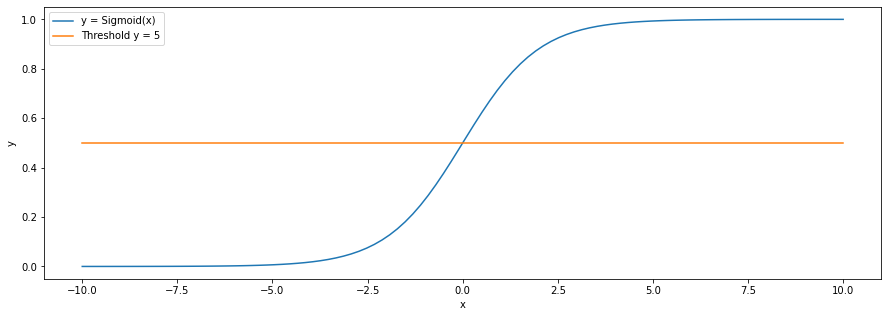

In [19]:
# Sigmoid function and a threshold for threshold value 0.5
x = np.linspace(-10, 10, 100)
y = 1/(1 + np.exp(-x))
threshold = np.full((100, 1), 0.5)

# Drawing the sigmoid function and threshold
plt.figure(figsize=(15,5))
plt.plot(x, y, label="y = Sigmoid(x)")
plt.plot(x,threshold, label="Threshold y = 5")
plt.legend(loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

To train a logistic regression model, we once again use Scikit's API. Since the Scikit API uses the 'Limited-memory Broyden–Fletcher–Goldfarb–Shanno' algorithm, the algorithm first failed to converge. However, increasing the amount of iterations of the algorithm to 1000 (default value was 100), caused the error of solving to only vary by a small range, thus letting it converge.

In [20]:
# Train the logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train["Win"].to_numpy())

# Calculate the score using cross validation
logreg_score = logreg.score(X_val, y_val['Win'])
print(logreg_score)

0.7314439946018894


The model scores relatively well, but alas it is not much different from the previous approaches.

## Model evaluation

In this section, the different models will be compared according to their hyperparameter tuning that was performed on the validation data. To compare the models, the cross-validation score is used on unseen test data.

Scores for model KNN: [0.65229111 0.67385445 0.68108108 0.65405405]
Scores for model DTC: [0.64959569 0.64420485 0.64054054 0.60810811]
Scores for model NN: [0.64690027 0.72506739 0.71351351 0.62432432]
Scores for model LG: [0.69811321 0.71428571 0.71081081 0.72162162]


Text(0.5, 0, 'Model')

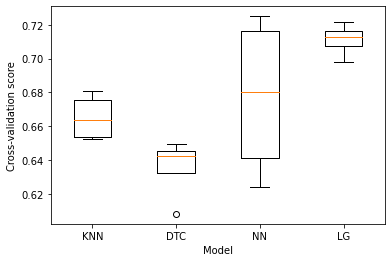

In [57]:
# Observed optimal parameter: k = 500
knn_model = KNeighborsClassifier(n_neighbors=4).fit(X_train, y_train['Win'].to_numpy())
# Observed optimal parameters: criterion = entropy, splitter = best, max_depth = 5
tree_model = DecisionTreeClassifier(criterion=best_tree_pms['criterion'], splitter=best_tree_pms['splitter'], max_depth=tree_max_score).fit(X_train, y_train['Win'].to_numpy())
# Neural network is already trained:
nn_model = mlp
# Logistic Regression model is already trained:
logreg_model = logreg

# Model data for plotting
model_names = ["KNN", "DTC", "NN", "LG"]
models = [knn_model, tree_model, nn_model, logreg_model]
model_results = []

# Model performance results
for i in range(len(models)):
    model = models[i]
    model_name = model_names[i]
    scores = cross_val_score(model, X_test, y_test['Win'].to_numpy(), cv=4)
    model_results.append(scores)
    print(f"Scores for model {model_name}: {scores}") 
    
# Plotting
data = zip(model_names, model_results)
plot_data = dict(data)
fig, ax = plt.subplots()
ax.boxplot(plot_data.values())
ax.set_xticklabels(plot_data.keys())
plt.ylabel("Cross-validation score")
plt.xlabel("Model")

On first sight we can see that the **Logistic Regression model** consistently yields higher accurracy compared to the other models, even reaching an accuracy of 72%. It seems to perform relatively consistent as well, with the cross-validation score ranging from 72% to 70%.

The model that seems to perform the worst on unseen data is the neural network. While it rivals the Logistic Regression models in the best cases, it is worthwhile to mention that the cross-validation score is very inconsistent, making it less reliable. It ranges from 62% to 73%.

The KNN method beats the Decision Tree classifier. KNN's cross-validation score ranges from 65% to 68%, while the Decision Tree Classifier's cross-validation score ranges from 61% to 65%. Though the lower bound of the range is an outlier, which seems to happen more with the DTC than the other models.